## International Airline Passenger - Window method

### Problem Description
The problem we are going to look at in this post is theInternational Airline Passengers prediction problem.

This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

** Name of the Dataset **  “international-airline-passengers.csv“

Some downloaded dataset also has footer information <br> that we can exclude with the skipfooter argument to pandas.read_csv() set to 3 for the 3 footer lines. 

** Example given below: **

In [1]:
import numpy
import pandas
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/home/gsbabu/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Some downloaded dataset also has footer information.
If that is the case then we can exclude with the skipfooter argument to pandas.read_csv() set to 3 for the 3 footer lines.

*** Example given below:***

Our data does NOT have footer !!

In [4]:
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[0,1], engine='python', skipfooter=3)
dataset.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


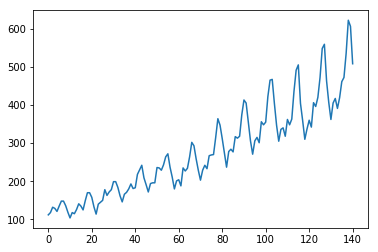

In [5]:
plt.plot(dataset['Passengers'])
plt.show()

Clearly there is an upward trend <br>
You can also see some periodicity to the dataset that probably corresponds to the Northern Hemisphere vacation period.

#### Normally, it is a good idea to investigate various data preparation techniques to rescale the data and to make it stationary.

***The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.***

There are three types of gates within a unit:
- **Forget Gate**: conditionally decides what information to throw away from the block.
- **Input Gate**: conditionally decides which values from the input to update the memory state.
- **Output Gate**: conditionally decides what to output based on input and the memory of the block.

### LMST Network Regression Types

- Simple : Given (t)    ====> predict (t+1)
- Window : Given (t-2), (t-1), (t) =====> predict (t+1)

#### LSTM Network for Regression

We can phrase the problem as a regression problem.

That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?

We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

Before we do anything, it is a good idea to fix the random number seed to ensure our results are reproducible

In [6]:
# fix random seed for reproducibility
numpy.random.seed(7)

We can load this dataset easily using the Pandas library. <br>
We are not interested in the date, given that each observation is separated by the same interval of one month. <br>
Therefore, when we load the dataset **we can exclude the first column**.

In [7]:
# load the dataset sales-of-soaps.csv
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python')
# dataframe = pandas.read_csv('sales-of-soaps.csv', usecols=[1], engine='python')


- ** extract the NumPy array from the dataframe** <br>
- Then **convert the integer values to floating point values**, which are more suitable for modeling with a neural network.

In [8]:
dataset = dataframe.values      ##   convert the data-frame to its Numpy-array
dataset = dataset.astype('float32')

### Important:
**LSTMs** are sensitive to the scale of the input data, specifically when the ***sigmoid (default)*** or ***tanh*** activation functions are used. <br>
It can be a good practice to rescale the data to the range of 0-to-1, also called ** normalizing**.<br>
We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [9]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Doing a Train-Test Split<br>
Train: 67%<br>
Test:  33%

In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


#### Cross Validation

##### When using time series data, the sequence of values is important. <br>

Now we can define a function to create a new dataset.

The function takes two arguments: the ***dataset***, which is a NumPy array that we want to convert into a dataset, and the ***look_back***, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t-1, t-1, t) and Y is the number of passengers at the next time (t + 1).

It can be configured, and we will be constructing a differently shaped dataset in the next section.

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

If you compare these first 5 rows to the original dataset sample listed in the previous section, you can see the X=t-2, t-1, t and Y=t+1 pattern in the numbers.



Let’s use this function to prepare the train and test datasets for modeling.

In [12]:
# reshape into X=t and Y=t+1
look_back = 12

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [13]:
trainX.shape[0]

83

In [14]:
trainX.shape[1]

12

In [15]:
trainX.shape

(83, 12)

In [16]:
trainX[0:5, :]

array([[0.01544401, 0.02702703, 0.05405405, 0.04826255, 0.03281853,
        0.05984557, 0.08494207, 0.08494207, 0.06177607, 0.02895753,
        0.        , 0.02702703],
       [0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984557,
        0.08494207, 0.08494207, 0.06177607, 0.02895753, 0.        ,
        0.02702703, 0.02123553],
       [0.05405405, 0.04826255, 0.03281853, 0.05984557, 0.08494207,
        0.08494207, 0.06177607, 0.02895753, 0.        , 0.02702703,
        0.02123553, 0.04247104],
       [0.04826255, 0.03281853, 0.05984557, 0.08494207, 0.08494207,
        0.06177607, 0.02895753, 0.        , 0.02702703, 0.02123553,
        0.04247104, 0.07142857],
       [0.03281853, 0.05984557, 0.08494207, 0.08494207, 0.06177607,
        0.02895753, 0.        , 0.02702703, 0.02123553, 0.04247104,
        0.07142857, 0.05984557]], dtype=float32)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of:** [samples, time steps, features]**.

Currently, our data is in the form:** [samples, features] ** [94, 1] and we are framing the problem as ***one time step*** for each sample.<br>
We can transform the prepared train and test input data into the expected structure using ***numpy.reshape()*** as follows:

### Excerpt from Stack exchange 
[ https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras]

*** LSTM shapes are tough need to spend a couple days battling:*** <br>
Here initially, x_train has the shape (1000, 8, 16)<br>

If you will be feeding data 1 character at a time your input shape should be (31,1) since your input has 31 timesteps, 1 character each. <br>
You will need to reshape your x_train from (1085420, 31) to (1085420, 31,1) which is easily done with this command :

 x_train=numpy.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [17]:
trainX.shape[0]

83

In [18]:
trainX.shape[1]

12

In [19]:
trainX.shape

(83, 12)

In [20]:
# reshape input to be [samples, time steps, features]

trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [21]:
# reshape input to be [samples, time steps, features]  - Original

# trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [22]:
trainX.shape

(83, 12, 1)

We are now ready to design and fit our LSTM network for this problem.

The network has :<br>
- a visible layer with 1 input<br>
- a hidden layer with 4 LSTM blocks or neurons<br>
- an output layer that makes a single value prediction. <br>

The default sigmoid activation function is used for the LSTM blocks. <br>
The network is trained for 100 epochs and a batch size of 1 is used.

In [23]:
# create the LSTM network
model = Sequential()
model.add(LSTM(8, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(8, return_sequences=True))
model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 8)             320       
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 8)             544       
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


In [25]:
%%time
# Fit the LSTM network
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

CPU times: user 8min 15s, sys: 1min 1s, total: 9min 16s
Wall time: 2min 15s


Once the model is fit, we can estimate the performance of the model on the train and test datasets.

In [26]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


***Note that we invert the predictions before calculating error scores 
to ensure that performance is reported in the same units as the original data (thousands of passengers per month).***

In [27]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [28]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 26.15 RMSE
Test Score: 69.45 RMSE


In [29]:
## Train Score: 23.70 RMSE Test Score: 58.87 RMSE (LSTM - 4) Lookback-3
## Train Score: 13.53 RMSE Test Score: 37.48 RMSE (LSTM - 64) Lookback-12

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

In [30]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

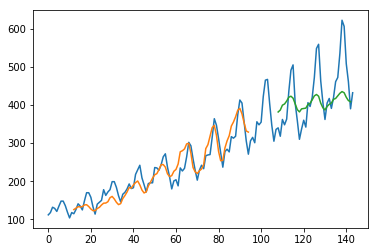

In [31]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()